In [ ]:
!cp /content/drive/MyDrive/laneTracking/*.jpg /content/drive/MyDrive/LaneTrackingSet/Images
print(len(glob.glob('//content/drive/MyDrive/LaneTrackingSet/Images/*.jpg')))

1966


In [ ]:
from pycocotools.coco import COCO
import skimage.io as io
import numpy as np
import zipfile
import glob
import os

def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

root_dir = '/content/drive/MyDrive/LaneTrackingSet'

anno_dir_pth = os.path.join(root_dir, 'Masks')
imgs_dir_pth = os.path.join(root_dir, 'Images')

raw_anno_dir_pth = os.path.join(root_dir, 'masks')
raw_imgs_dir_pth = os.path.join(root_dir, 'images')
counts = [0, 0]
anno_files = glob.glob(raw_anno_dir_pth + '/*.json')
for anno_file in anno_files:

  # unzip the corresponding archive
  # img_zip_path = os.path.join(raw_imgs_dir_pth, anno_file.split('.')[-2].split('/')[-1] + '.zip')
  # with zipfile.ZipFile(img_zip_path, 'r') as zip_ref:
    # zip_ref.extractall(imgs_dir_pth)

  # initialize the COCO api for instance annotations
  coco = COCO(anno_file)

  # load the categories in a variable
  catIDs = coco.getCatIds()
  cats = coco.loadCats(catIDs)

  # get all images containing the above Category IDs
  imgIds = coco.getImgIds(catIds=catIDs)
  print(len(imgIds))

  for id in range(len(imgIds)):
    img = coco.loadImgs(imgIds[id])[0]

    annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIDs, iscrowd=None)
    anns = coco.loadAnns(annIds)

    # generate segmentation mask
    # filterClasses = ['Lanes']
    mask = np.zeros((img['height'], img['width']))

    for i in range(len(anns)):
        # className = getClassName(anns[i]['category_id'], cats)
        #if className == 'pink':
        pixel_value = 1#filterClasses.index(className) + 1
        mask = np.maximum(coco.annToMask(anns[i]) * pixel_value, mask)

    _, _counts = np.unique(mask.reshape(-1, 1), return_counts = True, axis = 0)
    counts = counts + _counts
    io.imsave('{}/Masks/{}'.format(root_dir, img['file_name']), mask)

In [ ]:
counts[0] / (counts[0] + counts[1]) * 100

96.96195360303223

In [ ]:
import json

masked_images = []
for anno_file in anno_files:
  with open(anno_file) as f:
    data = json.load(f)
    for i in range(len(data['images'])):
      masked_images.append(data['images'][i]['file_name'])

for img in masked_images:
  image_list = glob.glob('/content/drive/MyDrive/LaneTracking2/*.jpg')
  if '/content/drive/MyDrive/LaneTracking2/' + img not in image_list: continue
  image = io.imread('{}/{}'.format('/content/drive/MyDrive/LaneTracking2', img))
  io.imsave('{}/Images/{}'.format('/content/drive/MyDrive/LaneSet', img), image)

In [ ]:
len(glob.glob('/content/drive/MyDrive/LaneSet/Images/*.jpg'))

67

In [ ]:
"""
Author: Manpreet Singh Minhas
Contact: msminhas at uwaterloo ca
"""
from pathlib import Path
from typing import Any, Callable, Optional

import numpy as np
from PIL import Image
from torchvision.datasets.vision import VisionDataset

class SegmentationDataset(VisionDataset):
    """A PyTorch dataset for image segmentation task.
    The dataset is compatible with torchvision transforms.
    The transforms passed would be applied to both the Images and Masks.
    """
    def __init__(self,
                 root: str,
                 image_folder: str,
                 mask_folder: str,
                 transforms: Optional[Callable] = None,
                 seed: int = None,
                 fraction: float = None,
                 subset: str = None,
                 image_color_mode: str = "rgb",
                 mask_color_mode: str = "grayscale") -> None:
        """
        Args:
            root (str): Root directory path.
            image_folder (str): Name of the folder that contains the images in the root directory.
            mask_folder (str): Name of the folder that contains the masks in the root directory.
            transforms (Optional[Callable], optional): A function/transform that takes in
            a sample and returns a transformed version.
            E.g, ``transforms.ToTensor`` for images. Defaults to None.
            seed (int, optional): Specify a seed for the train and test split for reproducible results. Defaults to None.
            fraction (float, optional): A float value from 0 to 1 which specifies the validation split fraction. Defaults to None.
            subset (str, optional): 'Train' or 'Test' to select the appropriate set. Defaults to None.
            image_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'rgb'.
            mask_color_mode (str, optional): 'rgb' or 'grayscale'. Defaults to 'grayscale'.
        Raises:
            OSError: If image folder doesn't exist in root.
            OSError: If mask folder doesn't exist in root.
            ValueError: If subset is not either 'Train' or 'Test'
            ValueError: If image_color_mode and mask_color_mode are either 'rgb' or 'grayscale'
        """
        super().__init__(root, transforms)

        image_folder_path = Path(self.root) / image_folder
        mask_folder_path = Path(self.root) / mask_folder
        if not image_folder_path.exists():
            raise OSError(f"{image_folder_path} does not exist.")
        if not mask_folder_path.exists():
            raise OSError(f"{mask_folder_path} does not exist.")

        if image_color_mode not in ["rgb", "grayscale"]:
            raise ValueError(
                f"{image_color_mode} is an invalid choice. Please enter from rgb grayscale."
            )

        self.image_color_mode = image_color_mode
        self.mask_color_mode = mask_color_mode

        if not fraction:

          self.image_names = sorted(image_folder_path.glob("*"))
          self.mask_names = sorted(mask_folder_path.glob("*"))

        else:
            if subset not in ["Train", "Test"]:
                raise (ValueError(
                    f"{subset} is not a valid input. Acceptable values are Train and Test."
                ))

            self.fraction = fraction
            self.image_list = np.array(sorted(image_folder_path.glob("*.jpg")))
            self.mask_list = np.array(sorted(mask_folder_path.glob("*.jpg")))

            a = set(map(lambda x: str(x).split('/')[-1], self.image_list))
            b = set(map(lambda x: str(x).split('/')[-1], self.mask_list))
            for img in a.difference(b):
              a.remove(img)
            self.image_list = np.array(list(a))
            for img in b.difference(a):
              b.remove(img)
            self.mask_list = np.array(list(b))
            print(a.difference(b), b.difference(a))

            if seed:
                np.random.seed(seed)
                indices = np.arange(len(self.image_list))
                np.random.shuffle(indices)
                self.image_list = self.image_list[indices]
                # self.mask_list = self.mask_list[indices]

            if subset == "Train":
                self.image_names = self.image_list[:int(
                    np.ceil(len(self.image_list) * (1 - self.fraction)))]
                # self.mask_names = self.mask_list[:int(
                    # np.ceil(len(self.mask_list) * (1 - self.fraction)))]
            else:
                self.image_names = self.image_list[
                    int(np.ceil(len(self.image_list) * (1 - self.fraction))):]
                # self.mask_names = self.mask_list[
                    # int(np.ceil(len(self.mask_list) * (1 - self.fraction))):]

        print(len(self.image_names))

    def __len__(self) -> int:
      return len(self.image_names)

    def __getitem__(self, index: int) -> Any:

        image_path = '/content/drive/MyDrive/LaneTrackingSet/Images/' + str(self.image_names[index]).split('/')[-1]
        mask_path = '/content/drive/MyDrive/LaneTrackingSet/Masks/' + str(self.image_names[index]).split('/')[-1]
        with open(image_path, "rb") as image_file, open(mask_path,
                                                        "rb") as mask_file:
            image = Image.open(image_file)
            if self.image_color_mode == "rgb":
                image = image.convert("RGB")
            elif self.image_color_mode == "grayscale":
                image = image.convert("L")
            mask = Image.open(mask_file)
            if self.mask_color_mode == "rgb":
                mask = mask.convert("RGB")
            elif self.mask_color_mode == "grayscale":
                mask = mask.convert("L")
            sample = {"image": image, "mask": mask}
            if self.transforms:
                sample["image"] = self.transforms(sample["image"])
                sample["mask"] = self.transforms(sample["mask"])
            return sample

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


def get_dataloader_single_folder(data_dir: str,
                                 image_folder: str = 'Images',
                                 mask_folder: str = 'Masks',
                                 fraction: float = 0.2,
                                 batch_size: int = 4):
    """Create train and test dataloader from a single directory containing
    the image and mask folders.
    Args:
        data_dir (str): Data directory path or root
        image_folder (str, optional): Image folder name. Defaults to 'Images'.
        mask_folder (str, optional): Mask folder name. Defaults to 'Masks'.
        fraction (float, optional): Fraction of Test set. Defaults to 0.2.
        batch_size (int, optional): Dataloader batch size. Defaults to 4.
    Returns:
        dataloaders: Returns dataloaders dictionary containing the
        Train and Test dataloaders.
    """

# augGeneratorArgs = dict(featurewise_center = False,
#                         samplewise_center = False,
#                         rotation_range = 5,
#                         width_shift_range = 0.01,
#                         height_shift_range = 0.01,
#                         brightness_range = (0.8,1.2),
#                         shear_range = 0.01,
#                         zoom_range = [1, 1.25],
#                         horizontal_flip = True,
#                         vertical_flip = False,
#                         fill_mode = 'reflect',
#                         data_format = 'channels_last')

    data_transforms = transforms.Compose([transforms.ToTensor(),
                                          transforms.Resize((512, 512)),
                                          transforms.ColorJitter()])

    image_datasets = {
        x: SegmentationDataset(data_dir,
                               image_folder=image_folder,
                               mask_folder=mask_folder,
                               seed=100,
                               fraction=fraction,
                               subset=x,
                               transforms=data_transforms)
        for x in ['Train', 'Test']
    }
    dataloaders = {
        x: DataLoader(image_datasets[x],
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=1)
        for x in ['Train', 'Test']
    }
    return dataloaders

In [ ]:
dataloaders = get_dataloader_single_folder(root_dir, 'Images', 'Masks', fraction=0.2, batch_size=3)

set() set()
189
set() set()
47


In [ ]:
""" DeepLabv3 Model download and change the head for your prediction"""
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead
from torchvision import models


def createDeepLabv3(outputchannels=1):
    """DeepLabv3 class with custom head
    Args:
        outputchannels (int, optional): The number of output channels
        in your dataset masks. Defaults to 1.
    Returns:
        model: Returns the DeepLabv3 model with the ResNet101 backbone.
    """
    model = models.segmentation.deeplabv3_resnet101(pretrained=True,
                                                    progress=True,
                                                    aux_loss=True)
    model.classifier = DeepLabHead(2048, outputchannels)
    model.aux_classifier = FCNHead(1024, outputchannels)
    model.train()
    return model

In [ ]:
def train_model(model, criterion, dataloaders, optimizer, metrics, bpath,
                num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10
    # Use gpu if available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer=torch.optim.Adam(model.parameters(), lr=1e-4)
    # Initialize the log file for training and testing loss and metrics
    fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
        [f'Train_{m}' for m in metrics.keys()] + \
        [f'Test_{m}' for m in metrics.keys()]
    with open(os.path.join(bpath, 'log.csv'), 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
        batchsummary = {a: [0] for a in fieldnames}

        for phase in ['Train', 'Test']:
            if phase == 'Train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            # Iterate over data.
            for sample in tqdm(iter(dataloaders[phase])):
                inputs = sample['image'].to(device)
                masks = sample['mask'].to(device)
                #print(inputs.shape, masks.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # track history if only in train
                with torch.set_grad_enabled(phase == 'Train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, masks)
                    y_pred = outputs['out'].data.cpu().numpy().ravel()
                    y_true = masks.data.cpu().numpy().ravel()
                    for name, metric in metrics.items():
                        if name == 'f1_score':
                            # Use a classification threshold of 0.1
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true > 0, y_pred > 0.1))
                        else:
                            batchsummary[f'{phase}_{name}'].append(
                                metric(y_true.astype('uint8'), y_pred))

                    # backward + optimize only if in training phase
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
            batchsummary['epoch'] = epoch
            epoch_loss = loss
            batchsummary[f'{phase}_loss'] = epoch_loss.item()
            print('{} Loss: {:.4f}'.format(phase, loss))
        for field in fieldnames[3:]:
            batchsummary[field] = np.mean(batchsummary[field])
        print(batchsummary)
        with open(os.path.join(bpath, 'log.csv'), 'a', newline='') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            writer.writerow(batchsummary)
            # deep copy the model
            if phase == 'Test' and loss < best_loss:
                best_loss = loss
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Lowest Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
import torch
import time
import copy
import os
import csv
from tqdm import tqdm
from sklearn.metrics import f1_score, roc_auc_score

def criterion(inputs, target):
  pos_weight = torch.ones_like(target) / 95.0  +  (1.0 - 1.0 / 95.0) * target
  pos_weight = pos_weight.to('cuda:0')

  losses = {}
  for name, x in inputs.items():
    losses[name] = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)(x, target)

  if len(losses) == 1:
    return losses['out']

  return losses['out'] + 0.5 * losses['aux']

model = createDeepLabv3()
dataloaders = dataloaders
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
metrics = metrics = {'f1_score': f1_score, 'auroc': roc_auc_score}
bpath = './'
num_epochs = 100
model = train_model(model, criterion, dataloaders, optimizer, metrics, bpath, num_epochs)

Epoch 1/100
----------














  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.50s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.15s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:57,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.13s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.13s/it]











 27

Train Loss: 0.2435















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.12it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.26it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.36it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.44it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.53it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.57it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.62it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.60it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.63it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.65it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.67it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.71it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.74it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.74it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.76it/s]











100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

Test Loss: 0.2344
{'epoch': 1, 'Train_loss': 0.2434973120689392, 'Test_loss': 0.23442769050598145, 'Train_f1_score': 0.6860675397057168, 'Train_auroc': 0.9477022595805011, 'Test_f1_score': 0.7219635951304723, 'Test_auroc': 0.9308576025670937}
Epoch 2/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.35s/it]











  6%|▋         | 4/63 [00:04<01:14,  1.27s/it]











  8%|▊         | 5/63 [00:06<01:11,  1.23s/it]











 10%|▉         | 6/63 [00:07<01:08,  1.20s/it]











 11%|█         | 7/63 [00:08<01:06,  1.18s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.17s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.16s/it]











 16%|█▌        | 10/63 [00:11<01:00,  1.14s/it]











 17%|█▋        | 11/63 [00:12<00:58,  1.13s/it]











 19%|█▉        | 12/63 [00:13<00:57,  1.12s/it]











 21%|██        | 13/63 [00:15<00:56,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:52,  1.12s/it]











 2

Train Loss: 0.1761















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.04it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.18it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.28it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.40it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.47it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.55it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.61it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.66it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.70it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.70it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.73it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.72it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.75it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.73it/s]











 94%|█████████▍| 15/16 [00:08<00:00,  1.75it/s]











100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

Test Loss: 0.1884
{'epoch': 2, 'Train_loss': 0.17613375186920166, 'Test_loss': 0.18838948011398315, 'Train_f1_score': 0.8105111094756021, 'Train_auroc': 0.978069985698441, 'Test_f1_score': 0.725097042910051, 'Test_auroc': 0.9317236203497509}
Epoch 3/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.53s/it]











  3%|▎         | 2/63 [00:02<01:25,  1.40s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.33s/it]











  6%|▋         | 4/63 [00:04<01:14,  1.26s/it]











  8%|▊         | 5/63 [00:06<01:11,  1.22s/it]











 10%|▉         | 6/63 [00:07<01:08,  1.20s/it]











 11%|█         | 7/63 [00:08<01:06,  1.18s/it]











 13%|█▎        | 8/63 [00:09<01:03,  1.16s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.16s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.15s/it]











 17%|█▋        | 11/63 [00:12<00:59,  1.15s/it]











 19%|█▉        | 12/63 [00:13<00:57,  1.13s/it]











 21%|██        | 13/63 [00:15<00:56,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.13s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.14s/it]











 2

Train Loss: 0.1317















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.33it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.42it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.51it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.59it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.62it/s]











 50%|█████     | 8/16 [00:04<00:04,  1.63it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.65it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.63it/s]











 69%|██████▉   | 11/16 [00:06<00:03,  1.66it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.68it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.71it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.74it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.76it/s]











100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

Test Loss: 0.1387
{'epoch': 3, 'Train_loss': 0.1316702663898468, 'Test_loss': 0.13868552446365356, 'Train_f1_score': 0.8225630915752057, 'Train_auroc': 0.9795386125485223, 'Test_f1_score': 0.7738296553380694, 'Test_auroc': 0.9354525524168237}
Epoch 4/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:33,  1.51s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.42s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.32s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:08,  1.20s/it]











 11%|█         | 7/63 [00:08<01:05,  1.17s/it]











 13%|█▎        | 8/63 [00:09<01:03,  1.16s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.16s/it]











 16%|█▌        | 10/63 [00:11<01:00,  1.15s/it]











 17%|█▋        | 11/63 [00:12<00:59,  1.14s/it]











 19%|█▉        | 12/63 [00:14<00:57,  1.13s/it]











 21%|██        | 13/63 [00:15<00:57,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.13s/it]











 2

Train Loss: 0.0995















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.07s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.09it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.35it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.52it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.54it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.61it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.65it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.69it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.69it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.69it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.72it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.76it/s]











100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

Test Loss: 0.1537
{'epoch': 4, 'Train_loss': 0.09954595565795898, 'Test_loss': 0.1536945402622223, 'Train_f1_score': 0.8298517043120268, 'Train_auroc': 0.9800519473329822, 'Test_f1_score': 0.7201794630045589, 'Test_auroc': 0.9260338150723664}
Epoch 5/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:25,  1.39s/it]











  3%|▎         | 2/63 [00:02<01:19,  1.31s/it]











  5%|▍         | 3/63 [00:03<01:16,  1.27s/it]











  6%|▋         | 4/63 [00:04<01:12,  1.22s/it]











  8%|▊         | 5/63 [00:05<01:09,  1.20s/it]











 10%|▉         | 6/63 [00:07<01:07,  1.19s/it]











 11%|█         | 7/63 [00:08<01:05,  1.18s/it]











 13%|█▎        | 8/63 [00:09<01:03,  1.16s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.15s/it]











 16%|█▌        | 10/63 [00:11<01:00,  1.14s/it]











 17%|█▋        | 11/63 [00:12<00:58,  1.13s/it]











 19%|█▉        | 12/63 [00:13<00:57,  1.13s/it]











 21%|██        | 13/63 [00:15<00:56,  1.13s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.13s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.13s/it]











 2

Train Loss: 0.0870















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.29it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.41it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.50it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.54it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.60it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.63it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.65it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.67it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.68it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.71it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.67it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.71it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.73it/s]











100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

Test Loss: 0.0882
{'epoch': 5, 'Train_loss': 0.08700539171695709, 'Test_loss': 0.08815918117761612, 'Train_f1_score': 0.8341952426850942, 'Train_auroc': 0.9799068826513422, 'Test_f1_score': 0.7772941815500476, 'Test_auroc': 0.9355563769703711}
Epoch 6/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.34s/it]











  6%|▋         | 4/63 [00:04<01:14,  1.27s/it]











  8%|▊         | 5/63 [00:06<01:10,  1.22s/it]











 10%|▉         | 6/63 [00:07<01:07,  1.19s/it]











 11%|█         | 7/63 [00:08<01:05,  1.17s/it]











 13%|█▎        | 8/63 [00:09<01:03,  1.16s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.15s/it]











 16%|█▌        | 10/63 [00:11<01:00,  1.15s/it]











 17%|█▋        | 11/63 [00:12<00:59,  1.14s/it]











 19%|█▉        | 12/63 [00:13<00:58,  1.14s/it]











 21%|██        | 13/63 [00:15<00:56,  1.13s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.13s/it]











 24%|██▍       | 15/63 [00:17<00:53,  1.12s/it]











 25%|██▌       | 16/63 [00:18<00:52,  1.12s/it]











 2

Train Loss: 0.0743















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.11it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.24it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.33it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.43it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.53it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.60it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.62it/s]











 50%|█████     | 8/16 [00:04<00:04,  1.66it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.67it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.64it/s]











 69%|██████▉   | 11/16 [00:06<00:03,  1.65it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.68it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.68it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.71it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.72it/s]











100%|██████████| 16/16 [00:09<00:00,  1.68it/s]

Test Loss: 0.0789
{'epoch': 6, 'Train_loss': 0.07426433265209198, 'Test_loss': 0.07885435223579407, 'Train_f1_score': 0.836542624608202, 'Train_auroc': 0.9808522830441421, 'Test_f1_score': 0.7751727190397473, 'Test_auroc': 0.9360136906399309}
Epoch 7/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.57s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:04<01:15,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:06,  1.19s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.17s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.15s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.15s/it]











 17%|█▋        | 11/63 [00:12<00:59,  1.14s/it]











 19%|█▉        | 12/63 [00:14<00:57,  1.13s/it]











 21%|██        | 13/63 [00:15<00:55,  1.12s/it]











 22%|██▏       | 14/63 [00:16<00:54,  1.11s/it]











 24%|██▍       | 15/63 [00:17<00:53,  1.12s/it]











 25%|██▌       | 16/63 [00:18<00:52,  1.12s/it]











 2

Train Loss: 0.0651















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:12,  1.23it/s]











 12%|█▎        | 2/16 [00:01<00:10,  1.36it/s]











 19%|█▉        | 3/16 [00:01<00:08,  1.46it/s]











 25%|██▌       | 4/16 [00:02<00:07,  1.53it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.57it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.55it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.55it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.60it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.65it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.68it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.69it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.68it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.70it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.73it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.74it/s]











100%|██████████| 16/16 [00:09<00:00,  1.69it/s]

Test Loss: 0.0748
{'epoch': 7, 'Train_loss': 0.0651479959487915, 'Test_loss': 0.07482069730758667, 'Train_f1_score': 0.8397106279127967, 'Train_auroc': 0.9811003063237147, 'Test_f1_score': 0.7629571241156297, 'Test_auroc': 0.9356483128636153}
Epoch 8/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:36,  1.56s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.33s/it]











  6%|▋         | 4/63 [00:04<01:14,  1.27s/it]











  8%|▊         | 5/63 [00:06<01:11,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:08,  1.19s/it]











 11%|█         | 7/63 [00:08<01:06,  1.18s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.16s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:12<00:59,  1.15s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.14s/it]











 21%|██        | 13/63 [00:15<00:57,  1.15s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.15s/it]











 2

Train Loss: 0.0649















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.11it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.25it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.37it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.46it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.51it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.55it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.59it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.62it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.63it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.67it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.67it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.69it/s]











 81%|████████▏ | 13/16 [00:07<00:01,  1.66it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.68it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.72it/s]











100%|██████████| 16/16 [00:09<00:00,  1.67it/s]

Test Loss: 0.0783
{'epoch': 8, 'Train_loss': 0.064896360039711, 'Test_loss': 0.07831637561321259, 'Train_f1_score': 0.8422811935244356, 'Train_auroc': 0.9814278146026398, 'Test_f1_score': 0.7966419359819836, 'Test_auroc': 0.9364436972019384}
Epoch 9/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.47s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.17s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<00:59,  1.15s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.14s/it]











 21%|██        | 13/63 [00:15<00:56,  1.13s/it]











 22%|██▏       | 14/63 [00:16<00:54,  1.12s/it]











 24%|██▍       | 15/63 [00:17<00:53,  1.11s/it]











 25%|██▌       | 16/63 [00:18<00:52,  1.11s/it]











 2

Train Loss: 0.0523















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.04it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.28it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.54it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.59it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.60it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.65it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.68it/s]











 69%|██████▉   | 11/16 [00:06<00:02,  1.70it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.65it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.65it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.66it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.69it/s]











100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

Test Loss: 0.0557
{'epoch': 9, 'Train_loss': 0.05226457491517067, 'Test_loss': 0.05566823109984398, 'Train_f1_score': 0.8416340476081872, 'Train_auroc': 0.9814799740101676, 'Test_f1_score': 0.7710929618951639, 'Test_auroc': 0.9361642080499982}
Epoch 10/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.57s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.45s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<00:59,  1.15s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.14s/it]











 21%|██        | 13/63 [00:15<00:57,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.13s/it]











 2

Train Loss: 0.0447















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.19it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.32it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.42it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.51it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.56it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.62it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.59it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.61it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.65it/s]











 69%|██████▉   | 11/16 [00:06<00:03,  1.64it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.67it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.66it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.67it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.70it/s]











100%|██████████| 16/16 [00:09<00:00,  1.65it/s]

Test Loss: 0.0497
{'epoch': 10, 'Train_loss': 0.044667162001132965, 'Test_loss': 0.04965828359127045, 'Train_f1_score': 0.8473979308396065, 'Train_auroc': 0.9817545901103859, 'Test_f1_score': 0.7697669135390883, 'Test_auroc': 0.9356495685157488}
Epoch 11/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:32,  1.50s/it]











  3%|▎         | 2/63 [00:02<01:25,  1.41s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.34s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.21s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.16s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:52,  1.13s/it]











 2

Train Loss: 0.0450















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.12it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.54it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.56it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.64it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.66it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.68it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.70it/s]











100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

Test Loss: 0.0521
{'epoch': 11, 'Train_loss': 0.04504420980811119, 'Test_loss': 0.052070893347263336, 'Train_f1_score': 0.8454882391100897, 'Train_auroc': 0.981827266800914, 'Test_f1_score': 0.7926818163182585, 'Test_auroc': 0.9364860481796627}
Epoch 12/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0342















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.08it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.30it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.40it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.49it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.53it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.56it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.58it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.62it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:06<00:03,  1.62it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.59it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

Test Loss: 0.0470
{'epoch': 12, 'Train_loss': 0.034180305898189545, 'Test_loss': 0.04700814187526703, 'Train_f1_score': 0.8481110429252061, 'Train_auroc': 0.9819511803008238, 'Test_f1_score': 0.7751014487178487, 'Test_auroc': 0.9347989584946451}
Epoch 13/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.64s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:57,  1.15s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0366















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.08it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.19it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.31it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.40it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.54it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.58it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.60it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.63it/s]











 69%|██████▉   | 11/16 [00:06<00:03,  1.63it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.66it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.67it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.71it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.72it/s]











100%|██████████| 16/16 [00:09<00:00,  1.64it/s]

Test Loss: 0.0482
{'epoch': 13, 'Train_loss': 0.03657204657793045, 'Test_loss': 0.04823552444577217, 'Train_f1_score': 0.8516767412476642, 'Train_auroc': 0.9820703072198328, 'Test_f1_score': 0.7607063255464435, 'Test_auroc': 0.9339485638762123}
Epoch 14/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:06,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.14s/it]











 2

Train Loss: 0.0318















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.05it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.28it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.60it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.63it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0353
{'epoch': 14, 'Train_loss': 0.031758662313222885, 'Test_loss': 0.035261575132608414, 'Train_f1_score': 0.8508174323901945, 'Train_auroc': 0.982159235997758, 'Test_f1_score': 0.7647468666175319, 'Test_auroc': 0.9342377164734877}
Epoch 15/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0368















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.11it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.23it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.33it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.41it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.51it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.50it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0519
{'epoch': 15, 'Train_loss': 0.03678194433450699, 'Test_loss': 0.05186790972948074, 'Train_f1_score': 0.8516024631349122, 'Train_auroc': 0.9821733219515103, 'Test_f1_score': 0.7761548971236305, 'Test_auroc': 0.9350390701851591}
Epoch 16/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:33,  1.51s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.41s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.33s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.21s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.16s/it]











 2

Train Loss: 0.0241















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.04it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.15it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.26it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.52it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.57it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.58it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.65it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.68it/s]











100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

Test Loss: 0.0442
{'epoch': 16, 'Train_loss': 0.024138499051332474, 'Test_loss': 0.04423895850777626, 'Train_f1_score': 0.8534351454512771, 'Train_auroc': 0.9822646271221429, 'Test_f1_score': 0.7666203359637103, 'Test_auroc': 0.9346793536189753}
Epoch 17/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.35s/it]











  6%|▋         | 4/63 [00:04<01:15,  1.28s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0266















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.21it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.31it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.40it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.48it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.52it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.50it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.62it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.65it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.65it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.68it/s]











100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

Test Loss: 0.0325
{'epoch': 17, 'Train_loss': 0.026573169976472855, 'Test_loss': 0.03254586458206177, 'Train_f1_score': 0.8581355785889009, 'Train_auroc': 0.9823828312098287, 'Test_f1_score': 0.765275203422262, 'Test_auroc': 0.9341927019716452}
Epoch 18/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.55s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:15,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.17s/it]











 2

Train Loss: 0.0235















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.11it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.19it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.29it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.39it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.48it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.49it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.54it/s]











 50%|█████     | 8/16 [00:05<00:04,  1.60it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.62it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.62it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]











100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

Test Loss: 0.0505
{'epoch': 18, 'Train_loss': 0.023481221869587898, 'Test_loss': 0.050466250628232956, 'Train_f1_score': 0.8558289302139706, 'Train_auroc': 0.9823470578489033, 'Test_f1_score': 0.7861242887437779, 'Test_auroc': 0.9347948468940974}
Epoch 19/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.15s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.14s/it]











 2

Train Loss: 0.0198















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.23it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.49it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.55it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.56it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.57it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.61it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.64it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.66it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.68it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.70it/s]











100%|██████████| 16/16 [00:09<00:00,  1.62it/s]

Test Loss: 0.0401
{'epoch': 19, 'Train_loss': 0.019776970148086548, 'Test_loss': 0.04007934778928757, 'Train_f1_score': 0.8574044245877973, 'Train_auroc': 0.9823989789076222, 'Test_f1_score': 0.7730586334439354, 'Test_auroc': 0.9337136391482201}
Epoch 20/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:27,  1.41s/it]











  3%|▎         | 2/63 [00:02<01:21,  1.33s/it]











  5%|▍         | 3/63 [00:03<01:17,  1.29s/it]











  6%|▋         | 4/63 [00:04<01:13,  1.25s/it]











  8%|▊         | 5/63 [00:06<01:09,  1.21s/it]











 10%|▉         | 6/63 [00:07<01:07,  1.18s/it]











 11%|█         | 7/63 [00:08<01:05,  1.16s/it]











 13%|█▎        | 8/63 [00:09<01:03,  1.16s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.15s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.15s/it]











 17%|█▋        | 11/63 [00:12<01:00,  1.15s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0216















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.31it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.42it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.52it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.55it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.55it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.58it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.61it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.57it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.62it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0313
{'epoch': 20, 'Train_loss': 0.021576644852757454, 'Test_loss': 0.03134539723396301, 'Train_f1_score': 0.8578440780925747, 'Train_auroc': 0.9824501937703789, 'Test_f1_score': 0.7799592008600995, 'Test_auroc': 0.9343187963086278}
Epoch 21/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.65s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.50s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.40s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.17s/it]











 2

Train Loss: 0.0218















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.08s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.07it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.19it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.30it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.57it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0394
{'epoch': 21, 'Train_loss': 0.021832408383488655, 'Test_loss': 0.03935611993074417, 'Train_f1_score': 0.8574082748370725, 'Train_auroc': 0.9824174220762292, 'Test_f1_score': 0.773780802617663, 'Test_auroc': 0.9333013664002563}
Epoch 22/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.57s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.45s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0200















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.02s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0394
{'epoch': 22, 'Train_loss': 0.01996501535177231, 'Test_loss': 0.039423562586307526, 'Train_f1_score': 0.8581347734583912, 'Train_auroc': 0.9824823054255931, 'Test_f1_score': 0.7922666886506687, 'Test_auroc': 0.9358534852566438}
Epoch 23/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0145















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.05it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.28it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.37it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.55it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.56it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0615
{'epoch': 23, 'Train_loss': 0.014452466741204262, 'Test_loss': 0.061494745314121246, 'Train_f1_score': 0.8595829740256397, 'Train_auroc': 0.982499532148783, 'Test_f1_score': 0.7830164951580914, 'Test_auroc': 0.9342713379629453}
Epoch 24/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:45,  1.70s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.54s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0193















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.06s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.07it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.20it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.29it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.37it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.60it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.61it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0330
{'epoch': 24, 'Train_loss': 0.01926453597843647, 'Test_loss': 0.03303965926170349, 'Train_f1_score': 0.8578227949863447, 'Train_auroc': 0.9825039993581695, 'Test_f1_score': 0.7828195482326953, 'Test_auroc': 0.9343783488927343}
Epoch 25/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.16s/it]











 2

Train Loss: 0.0208















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.12it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.58it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.60it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.60it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.63it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0287
{'epoch': 25, 'Train_loss': 0.020781926810741425, 'Test_loss': 0.028705673292279243, 'Train_f1_score': 0.8584067907749003, 'Train_auroc': 0.9824908894664073, 'Test_f1_score': 0.7615624517145252, 'Test_auroc': 0.9330989515826895}
Epoch 26/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.55s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.35s/it]











  6%|▋         | 4/63 [00:04<01:15,  1.28s/it]











  8%|▊         | 5/63 [00:06<01:11,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.21s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.15s/it]











 2

Train Loss: 0.0199















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.00it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.10it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.50it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.59it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.59it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.57it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0236
{'epoch': 26, 'Train_loss': 0.01985655538737774, 'Test_loss': 0.02362363412976265, 'Train_f1_score': 0.8573909285808374, 'Train_auroc': 0.9824910207190276, 'Test_f1_score': 0.7899786960278109, 'Test_auroc': 0.9347920551455761}
Epoch 27/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.45s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:57,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.16s/it]











 2

Train Loss: 0.0121















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.02s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.12it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0694
{'epoch': 27, 'Train_loss': 0.012088868767023087, 'Test_loss': 0.06935548782348633, 'Train_f1_score': 0.8598599909738738, 'Train_auroc': 0.9825466427598167, 'Test_f1_score': 0.7720110238160065, 'Test_auroc': 0.9315204667175248}
Epoch 28/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0128















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.04s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.09it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.57it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0338
{'epoch': 28, 'Train_loss': 0.012807763181626797, 'Test_loss': 0.03378696367144585, 'Train_f1_score': 0.8587777172291499, 'Train_auroc': 0.9825812453635607, 'Test_f1_score': 0.7741255732915444, 'Test_auroc': 0.931426479139002}
Epoch 29/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:31,  1.47s/it]











  3%|▎         | 2/63 [00:02<01:24,  1.39s/it]











  5%|▍         | 3/63 [00:03<01:18,  1.31s/it]











  6%|▋         | 4/63 [00:04<01:14,  1.27s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:08,  1.21s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.15s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.16s/it]











 2

Train Loss: 0.0143















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.62it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0889
{'epoch': 29, 'Train_loss': 0.014317726716399193, 'Test_loss': 0.08886581659317017, 'Train_f1_score': 0.8592828582686567, 'Train_auroc': 0.9825940919239806, 'Test_f1_score': 0.7665517008291876, 'Test_auroc': 0.9311265373443353}
Epoch 30/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.14s/it]











 21%|██        | 13/63 [00:15<00:57,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.13s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.13s/it]











 2

Train Loss: 0.0149















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.61it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.63it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.59it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0391
{'epoch': 30, 'Train_loss': 0.014914966188371181, 'Test_loss': 0.039088618010282516, 'Train_f1_score': 0.8613809085647978, 'Train_auroc': 0.9824552354179555, 'Test_f1_score': 0.7719771215532392, 'Test_auroc': 0.9318837081125136}
Epoch 31/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:56,  1.13s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.13s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.13s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.14s/it]











 2

Train Loss: 0.0154















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.04it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.35it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0406
{'epoch': 31, 'Train_loss': 0.015402143821120262, 'Test_loss': 0.04059593752026558, 'Train_f1_score': 0.8608664996040158, 'Train_auroc': 0.9825765850539369, 'Test_f1_score': 0.7819616461303374, 'Test_auroc': 0.9329473394165599}
Epoch 32/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:46,  1.72s/it]











  3%|▎         | 2/63 [00:02<01:36,  1.59s/it]











  5%|▍         | 3/63 [00:04<01:28,  1.47s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0147















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.18it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.49it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.64it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.65it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0266
{'epoch': 32, 'Train_loss': 0.014702657237648964, 'Test_loss': 0.02661743387579918, 'Train_f1_score': 0.8602880550854555, 'Train_auroc': 0.982592380248196, 'Test_f1_score': 0.7595105614039791, 'Test_auroc': 0.9300915575558564}
Epoch 33/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.54s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.15s/it]











 2

Train Loss: 0.0102















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.07it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0855
{'epoch': 33, 'Train_loss': 0.010242369025945663, 'Test_loss': 0.08548328280448914, 'Train_f1_score': 0.8600420355107357, 'Train_auroc': 0.9826047543741123, 'Test_f1_score': 0.778784619619282, 'Test_auroc': 0.9311215858480657}
Epoch 34/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:24,  1.36s/it]











  3%|▎         | 2/63 [00:02<01:18,  1.29s/it]











  5%|▍         | 3/63 [00:03<01:15,  1.26s/it]











  6%|▋         | 4/63 [00:04<01:12,  1.23s/it]











  8%|▊         | 5/63 [00:05<01:09,  1.19s/it]











 10%|▉         | 6/63 [00:07<01:07,  1.19s/it]











 11%|█         | 7/63 [00:08<01:05,  1.18s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:12<01:00,  1.15s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:18<00:56,  1.20s/it]











 2

Train Loss: 0.0128















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:12,  1.17it/s]











 12%|█▎        | 2/16 [00:01<00:10,  1.28it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.38it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.45it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.48it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.50it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.50it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0269
{'epoch': 34, 'Train_loss': 0.012825386598706245, 'Test_loss': 0.02685583010315895, 'Train_f1_score': 0.8614841960604982, 'Train_auroc': 0.9826153103977727, 'Test_f1_score': 0.7828961475240824, 'Test_auroc': 0.9326035443452865}
Epoch 35/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.40s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:12<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0134















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.05it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.18it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.28it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.37it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.60it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.60it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.57it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.61it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0168
{'epoch': 35, 'Train_loss': 0.01338571310043335, 'Test_loss': 0.016754750162363052, 'Train_f1_score': 0.8621222186036079, 'Train_auroc': 0.9826395407345059, 'Test_f1_score': 0.7810764966474302, 'Test_auroc': 0.9325120955017054}
Epoch 36/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:34,  1.53s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:57,  1.15s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.15s/it]











 2

Train Loss: 0.0130















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.21it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.31it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.37it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.54it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.58it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.57it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.54it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0374
{'epoch': 36, 'Train_loss': 0.013005886226892471, 'Test_loss': 0.03740246221423149, 'Train_f1_score': 0.8614082096952052, 'Train_auroc': 0.9826481708057135, 'Test_f1_score': 0.7780077391535525, 'Test_auroc': 0.9314641878013552}
Epoch 37/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:08,  1.21s/it]











 11%|█         | 7/63 [00:08<01:06,  1.18s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.21s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0114















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.26it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.35it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.61it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0275
{'epoch': 37, 'Train_loss': 0.011378956958651543, 'Test_loss': 0.027521520853042603, 'Train_f1_score': 0.8613047663753879, 'Train_auroc': 0.9826617324310225, 'Test_f1_score': 0.7791650419886783, 'Test_auroc': 0.9299834802762197}
Epoch 38/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.60s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.47s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.17s/it]











 2

Train Loss: 0.0091















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.10it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.58it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0454
{'epoch': 38, 'Train_loss': 0.009098753333091736, 'Test_loss': 0.04537426680326462, 'Train_f1_score': 0.8625086470499895, 'Train_auroc': 0.9826625435189708, 'Test_f1_score': 0.7672723204781775, 'Test_auroc': 0.9286662260491673}
Epoch 39/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:34,  1.52s/it]











  3%|▎         | 2/63 [00:02<01:25,  1.40s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.33s/it]











  6%|▋         | 4/63 [00:05<01:15,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.23s/it]











 11%|█         | 7/63 [00:08<01:06,  1.19s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.17s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:18<00:55,  1.17s/it]











 2

Train Loss: 0.0091















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.31it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.37it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.55it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.61it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.64it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0369
{'epoch': 39, 'Train_loss': 0.009064959362149239, 'Test_loss': 0.03688046336174011, 'Train_f1_score': 0.8613873705557094, 'Train_auroc': 0.9826788144974158, 'Test_f1_score': 0.7840358437214533, 'Test_auroc': 0.9323382084948614}
Epoch 40/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:44,  1.68s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.54s/it]











  5%|▍         | 3/63 [00:04<01:26,  1.44s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0088















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.02it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.35it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.39it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.52it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.62it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.61it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0264
{'epoch': 40, 'Train_loss': 0.008780103176832199, 'Test_loss': 0.026427991688251495, 'Train_f1_score': 0.8629202942966916, 'Train_auroc': 0.9826673118576564, 'Test_f1_score': 0.7821585858915627, 'Test_auroc': 0.9316159256843102}
Epoch 41/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.54s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.14s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0113















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.01s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.59it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.61it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.57it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0344
{'epoch': 41, 'Train_loss': 0.011261098086833954, 'Test_loss': 0.034378647804260254, 'Train_f1_score': 0.8614475559611362, 'Train_auroc': 0.9826749489164954, 'Test_f1_score': 0.7824023160887836, 'Test_auroc': 0.9308709467817229}
Epoch 42/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:18<00:55,  1.18s/it]











 2

Train Loss: 0.0106















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.52it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.55it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.49it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.51it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.55it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0342
{'epoch': 42, 'Train_loss': 0.010589729994535446, 'Test_loss': 0.034182749688625336, 'Train_f1_score': 0.8617394396412094, 'Train_auroc': 0.9826827612509103, 'Test_f1_score': 0.7798569293671056, 'Test_auroc': 0.930830248332718}
Epoch 43/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0103















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.55it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.65it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.68it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.70it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0245
{'epoch': 43, 'Train_loss': 0.010322840884327888, 'Test_loss': 0.024502083659172058, 'Train_f1_score': 0.8617911608701245, 'Train_auroc': 0.9826802903963028, 'Test_f1_score': 0.781644602350327, 'Test_auroc': 0.9316509105489004}
Epoch 44/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.49s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.40s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:10<01:05,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.17s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0113















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.22it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.30it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.45it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.56it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.61it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.61it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.59it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.59it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.60it/s]

Test Loss: 0.0409
{'epoch': 44, 'Train_loss': 0.011272989213466644, 'Test_loss': 0.040901754051446915, 'Train_f1_score': 0.8624813676315485, 'Train_auroc': 0.9826985204394925, 'Test_f1_score': 0.7789279401172011, 'Test_auroc': 0.9313170148830983}
Epoch 45/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.15s/it]











 2

Train Loss: 0.0084















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.04s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.08it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.19it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.29it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.35it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0394
{'epoch': 45, 'Train_loss': 0.00838414765894413, 'Test_loss': 0.039396073669195175, 'Train_f1_score': 0.8621248951160267, 'Train_auroc': 0.9826794912732421, 'Test_f1_score': 0.7833724686546882, 'Test_auroc': 0.931373768588316}
Epoch 46/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.65s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.50s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.15s/it]











 2

Train Loss: 0.0111















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.04it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.30it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.49it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.51it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.58it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0432
{'epoch': 46, 'Train_loss': 0.011099692434072495, 'Test_loss': 0.043184712529182434, 'Train_f1_score': 0.8612141941628695, 'Train_auroc': 0.9826885737153779, 'Test_f1_score': 0.7771936600689409, 'Test_auroc': 0.9311761077164625}
Epoch 47/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.17s/it]











 2

Train Loss: 0.0117















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.26it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.56it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0487
{'epoch': 47, 'Train_loss': 0.011744258925318718, 'Test_loss': 0.04867678880691528, 'Train_f1_score': 0.861654235421164, 'Train_auroc': 0.9826979249338421, 'Test_f1_score': 0.7812184085067716, 'Test_auroc': 0.9299590117233484}
Epoch 48/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.67s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:03<01:24,  1.40s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:14,  1.30s/it]











 11%|█         | 7/63 [00:08<01:11,  1.27s/it]











 13%|█▎        | 8/63 [00:10<01:07,  1.23s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:18<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.17s/it]











 2

Train Loss: 0.0289















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.09s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.04it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.30it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.43it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.55it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.61it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0625
{'epoch': 48, 'Train_loss': 0.02886733040213585, 'Test_loss': 0.06247913837432861, 'Train_f1_score': 0.8535586435030529, 'Train_auroc': 0.9812377582440444, 'Test_f1_score': 0.7516936550878695, 'Test_auroc': 0.9287002549483306}
Epoch 49/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:36,  1.55s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0249















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.04s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.09it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.56it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.64it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.68it/s]











100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

Test Loss: 0.0271
{'epoch': 49, 'Train_loss': 0.024853087961673737, 'Test_loss': 0.027139538899064064, 'Train_f1_score': 0.8245791124745738, 'Train_auroc': 0.9807673206033563, 'Test_f1_score': 0.7730304782553893, 'Test_auroc': 0.9366020114704167}
Epoch 50/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:31,  1.47s/it]











  3%|▎         | 2/63 [00:02<01:22,  1.36s/it]











  5%|▍         | 3/63 [00:03<01:18,  1.31s/it]











  6%|▋         | 4/63 [00:04<01:14,  1.26s/it]











  8%|▊         | 5/63 [00:06<01:11,  1.23s/it]











 10%|▉         | 6/63 [00:07<01:07,  1.19s/it]











 11%|█         | 7/63 [00:08<01:04,  1.16s/it]











 13%|█▎        | 8/63 [00:09<01:03,  1.15s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:12<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.16s/it]











 2

Train Loss: 0.0155















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.02it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.44it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.46it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.52it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.62it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0328
{'epoch': 50, 'Train_loss': 0.015460656024515629, 'Test_loss': 0.032799649983644485, 'Train_f1_score': 0.8506582949553807, 'Train_auroc': 0.9821968508138027, 'Test_f1_score': 0.7760097054906865, 'Test_auroc': 0.9355572074192429}
Epoch 51/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.65s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.50s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:19<00:53,  1.14s/it]











 2

Train Loss: 0.0095















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.03it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.35it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.38it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.55it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.58it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0270
{'epoch': 51, 'Train_loss': 0.00952840968966484, 'Test_loss': 0.0270405113697052, 'Train_f1_score': 0.8566375854421393, 'Train_auroc': 0.9825170745884857, 'Test_f1_score': 0.7817863854766093, 'Test_auroc': 0.9337659723328577}
Epoch 52/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.66s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:56,  1.14s/it]











 22%|██▏       | 14/63 [00:16<00:55,  1.14s/it]











 24%|██▍       | 15/63 [00:17<00:54,  1.13s/it]











 25%|██▌       | 16/63 [00:18<00:53,  1.15s/it]











 2

Train Loss: 0.0108















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.12it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.23it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.30it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.49it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.55it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.58it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.64it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.67it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.70it/s]











100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

Test Loss: 0.0314
{'epoch': 52, 'Train_loss': 0.010779410600662231, 'Test_loss': 0.03135775029659271, 'Train_f1_score': 0.8592332015667736, 'Train_auroc': 0.982565619756024, 'Test_f1_score': 0.7821862391896989, 'Test_auroc': 0.9335966914684224}
Epoch 53/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:34,  1.52s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.42s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.33s/it]











  6%|▋         | 4/63 [00:04<01:15,  1.28s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<01:00,  1.20s/it]











 22%|██▏       | 14/63 [00:16<01:00,  1.23s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.19s/it]











 2

Train Loss: 0.0100















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.08s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.06it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.38it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.63it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0301
{'epoch': 53, 'Train_loss': 0.010013886727392673, 'Test_loss': 0.03013135865330696, 'Train_f1_score': 0.8608479609607443, 'Train_auroc': 0.9826483666802293, 'Test_f1_score': 0.7623585171722034, 'Test_auroc': 0.9296696433055552}
Epoch 54/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.45s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.23s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.20s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0095















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.03it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.25it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.35it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.48it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.64it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0282
{'epoch': 54, 'Train_loss': 0.009501852095127106, 'Test_loss': 0.02822825126349926, 'Train_f1_score': 0.8609513245879346, 'Train_auroc': 0.982680880913155, 'Test_f1_score': 0.7866596287930552, 'Test_auroc': 0.9323600481933209}
Epoch 55/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.66s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:03<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0101















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.21it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.30it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.39it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.60it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.57it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.59it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0319
{'epoch': 55, 'Train_loss': 0.010110469534993172, 'Test_loss': 0.03194056451320648, 'Train_f1_score': 0.8615970173095263, 'Train_auroc': 0.9826887393148382, 'Test_f1_score': 0.7785600240718722, 'Test_auroc': 0.9310915725471676}
Epoch 56/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.67s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.15s/it]











 2

Train Loss: 0.0084















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.04it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.15it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.25it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.56it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.59it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.64it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0217
{'epoch': 56, 'Train_loss': 0.008364379405975342, 'Test_loss': 0.021713271737098694, 'Train_f1_score': 0.8618931940451632, 'Train_auroc': 0.9826953573809903, 'Test_f1_score': 0.783480414164313, 'Test_auroc': 0.9320235238960541}
Epoch 57/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.47s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:09,  1.25s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.23s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0112















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.13it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.26it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.35it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.41it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.45it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.56it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.60it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.52it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.50it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.55it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.58it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0389
{'epoch': 57, 'Train_loss': 0.011236496269702911, 'Test_loss': 0.03886584937572479, 'Train_f1_score': 0.8625918255391765, 'Train_auroc': 0.9827336042351263, 'Test_f1_score': 0.7769480232545767, 'Test_auroc': 0.9296093004034097}
Epoch 58/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.60s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.25s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0071















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.54it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.59it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.60it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.62it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.62it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.61it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

Test Loss: 0.0352
{'epoch': 58, 'Train_loss': 0.007057500071823597, 'Test_loss': 0.03524786978960037, 'Train_f1_score': 0.8626509431555136, 'Train_auroc': 0.9827277954168913, 'Test_f1_score': 0.777779170489942, 'Test_auroc': 0.9303595489574376}
Epoch 59/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:04,  1.17s/it]











 14%|█▍        | 9/63 [00:10<01:02,  1.16s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.16s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.17s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.16s/it]











 2

Train Loss: 0.0106















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.14it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.26it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.36it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.42it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.48it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.51it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.55it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.59it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.57it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.54it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.59it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.59it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:09<00:00,  1.61it/s]

Test Loss: 0.1276
{'epoch': 59, 'Train_loss': 0.010558117181062698, 'Test_loss': 0.1275920569896698, 'Train_f1_score': 0.8631611097530352, 'Train_auroc': 0.9827402318604483, 'Test_f1_score': 0.7786598044824229, 'Test_auroc': 0.929722507040636}
Epoch 60/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:36,  1.56s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:11<01:01,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0092















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.08it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.19it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.37it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.57it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.59it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.62it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.63it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.65it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]











100%|██████████| 16/16 [00:09<00:00,  1.60it/s]

Test Loss: 0.0420
{'epoch': 60, 'Train_loss': 0.009225857444107533, 'Test_loss': 0.04204864799976349, 'Train_f1_score': 0.8634574276333149, 'Train_auroc': 0.9827512022397603, 'Test_f1_score': 0.7774158213178136, 'Test_auroc': 0.9303339746591409}
Epoch 61/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.40s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.18s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.19s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.19s/it]











 2

Train Loss: 0.0091















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.05it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.14it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.39it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.47it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.53it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.65it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.68it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0631
{'epoch': 61, 'Train_loss': 0.009071659296751022, 'Test_loss': 0.06305291503667831, 'Train_f1_score': 0.8636492036907784, 'Train_auroc': 0.9827435816973005, 'Test_f1_score': 0.7773551042640219, 'Test_auroc': 0.930652611662931}
Epoch 62/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.53s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.42s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.21s/it]











 11%|█         | 7/63 [00:08<01:06,  1.19s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.18s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.18s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.19s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0082















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.04s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.10it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.20it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.30it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.38it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.43it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.44it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.46it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.49it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.50it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.51it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.54it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.55it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.59it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.62it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0589
{'epoch': 62, 'Train_loss': 0.008153093978762627, 'Test_loss': 0.058918602764606476, 'Train_f1_score': 0.8630225654869313, 'Train_auroc': 0.9827596345410714, 'Test_f1_score': 0.7774265277580615, 'Test_auroc': 0.9303361346137212}
Epoch 63/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.47s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0072















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.00s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.54it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.54it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.58it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.58it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0309
{'epoch': 63, 'Train_loss': 0.007201730273663998, 'Test_loss': 0.0308606568723917, 'Train_f1_score': 0.8632976782094245, 'Train_auroc': 0.9827674887418105, 'Test_f1_score': 0.7789799423564262, 'Test_auroc': 0.9302463863387025}
Epoch 64/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.64s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.51s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0070















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.07it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.30it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.48it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.50it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.57it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0485
{'epoch': 64, 'Train_loss': 0.006984408013522625, 'Test_loss': 0.04850214347243309, 'Train_f1_score': 0.8621847022872381, 'Train_auroc': 0.9827588704331021, 'Test_f1_score': 0.7739931161172614, 'Test_auroc': 0.9288168393716758}
Epoch 65/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.67s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.43s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:09,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.20s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.19s/it]











 2

Train Loss: 0.0088















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.01s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.10it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.23it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.53it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.55it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.60it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.64it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0264
{'epoch': 65, 'Train_loss': 0.008806069381535053, 'Test_loss': 0.02636714279651642, 'Train_f1_score': 0.8632365176394671, 'Train_auroc': 0.9827556933300778, 'Test_f1_score': 0.7823983051338274, 'Test_auroc': 0.9306844006515148}
Epoch 66/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.57s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.23s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0089















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:14,  1.00it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.25it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.37it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.61it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.56it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.55it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.58it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.57it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0273
{'epoch': 66, 'Train_loss': 0.008902586996555328, 'Test_loss': 0.027273772284388542, 'Train_f1_score': 0.8627707074571986, 'Train_auroc': 0.9827587010125779, 'Test_f1_score': 0.7724350621655118, 'Test_auroc': 0.9287760366385385}
Epoch 67/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.60s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0060















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.07it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.26it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.50it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.52it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.55it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.59it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.63it/s]











 88%|████████▊ | 14/16 [00:08<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.59it/s]

Test Loss: 0.0186
{'epoch': 67, 'Train_loss': 0.006046299356967211, 'Test_loss': 0.01864842139184475, 'Train_f1_score': 0.8629408459105514, 'Train_auroc': 0.9827459933267796, 'Test_f1_score': 0.7763569839601898, 'Test_auroc': 0.9304095602318889}
Epoch 68/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.60s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.30s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.21s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:58,  1.15s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:18<00:54,  1.17s/it]











 2

Train Loss: 0.0064















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.23it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.33it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.39it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.46it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.58it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.61it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0261
{'epoch': 68, 'Train_loss': 0.0064381444826722145, 'Test_loss': 0.026141773909330368, 'Train_f1_score': 0.8633984411366307, 'Train_auroc': 0.9827741775866813, 'Test_f1_score': 0.7718158221580552, 'Test_auroc': 0.9293008068488903}
Epoch 69/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:33,  1.51s/it]











  3%|▎         | 2/63 [00:02<01:24,  1.39s/it]











  5%|▍         | 3/63 [00:03<01:19,  1.32s/it]











  6%|▋         | 4/63 [00:04<01:15,  1.27s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.24s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.23s/it]











 11%|█         | 7/63 [00:08<01:06,  1.19s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:11<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<01:00,  1.21s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0087















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.11s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.05it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.27it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.37it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.46it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.55it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

Test Loss: 0.1130
{'epoch': 69, 'Train_loss': 0.008736131712794304, 'Test_loss': 0.11302066594362259, 'Train_f1_score': 0.8626011472476518, 'Train_auroc': 0.9827792155016899, 'Test_f1_score': 0.7762985606888845, 'Test_auroc': 0.9297032072041737}
Epoch 70/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.49s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.23s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.18s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0046















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.00s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.23it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.39it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.43it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.47it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.57it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.53it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.58it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0441
{'epoch': 70, 'Train_loss': 0.004625470377504826, 'Test_loss': 0.04407716169953346, 'Train_f1_score': 0.8637001965595167, 'Train_auroc': 0.9827720671362434, 'Test_f1_score': 0.7747886257262406, 'Test_auroc': 0.9283685681017237}
Epoch 71/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.15s/it]











 24%|██▍       | 15/63 [00:17<00:55,  1.15s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0062















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.10s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.05it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.16it/s]











 25%|██▌       | 4/16 [00:03<00:09,  1.24it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.38it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.47it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.53it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

Test Loss: 0.0353
{'epoch': 71, 'Train_loss': 0.006191273685544729, 'Test_loss': 0.035267677158117294, 'Train_f1_score': 0.8641786405870715, 'Train_auroc': 0.9827747245222431, 'Test_f1_score': 0.7802691584645755, 'Test_auroc': 0.930614702092026}
Epoch 72/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.60s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:04<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:16,  1.32s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.27s/it]











 11%|█         | 7/63 [00:08<01:09,  1.25s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.22s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.22s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:17<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.17s/it]











 2

Train Loss: 0.0082















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.12it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.23it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.42it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.43it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.58it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.61it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0436
{'epoch': 72, 'Train_loss': 0.008200529962778091, 'Test_loss': 0.04362284392118454, 'Train_f1_score': 0.8637171533458866, 'Train_auroc': 0.9827800280833456, 'Test_f1_score': 0.78247899161661, 'Test_auroc': 0.9308208865004552}
Epoch 73/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.66s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0052















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:12,  1.16it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.27it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.34it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.40it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.47it/s]











 38%|███▊      | 6/16 [00:03<00:06,  1.51it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.56it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.60it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.53it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.56it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.60it/s]











100%|██████████| 16/16 [00:10<00:00,  1.58it/s]

Test Loss: 0.0262
{'epoch': 73, 'Train_loss': 0.005190164782106876, 'Test_loss': 0.02623380348086357, 'Train_f1_score': 0.8639191374540032, 'Train_auroc': 0.9828125117143247, 'Test_f1_score': 0.7815135561437172, 'Test_auroc': 0.929966756263267}
Epoch 74/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:44,  1.68s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.53s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.16s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:57,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0073















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.09it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.28it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.36it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.43it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.47it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.49it/s]











 62%|██████▎   | 10/16 [00:06<00:04,  1.48it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.42it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.43it/s]











 81%|████████▏ | 13/16 [00:08<00:02,  1.47it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.51it/s]











 94%|█████████▍| 15/16 [00:10<00:00,  1.54it/s]











100%|██████████| 16/16 [00:10<00:00,  1.49it/s]

Test Loss: 0.0305
{'epoch': 74, 'Train_loss': 0.00725490041077137, 'Test_loss': 0.030491778627038002, 'Train_f1_score': 0.863999837058369, 'Train_auroc': 0.9827870762329061, 'Test_f1_score': 0.7798876630613556, 'Test_auroc': 0.9304156637699371}
Epoch 75/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:16,  1.31s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.28s/it]











 11%|█         | 7/63 [00:08<01:10,  1.25s/it]











 13%|█▎        | 8/63 [00:10<01:08,  1.25s/it]











 14%|█▍        | 9/63 [00:11<01:06,  1.23s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.21s/it]











 17%|█▋        | 11/63 [00:13<01:03,  1.22s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.21s/it]











 21%|██        | 13/63 [00:16<01:00,  1.21s/it]











 22%|██▏       | 14/63 [00:17<00:59,  1.21s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.21s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.21s/it]











 2

Train Loss: 0.0078















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.06s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.07it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.20it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.34it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.38it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.43it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.47it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:04,  1.49it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.50it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.50it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.53it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.54it/s]











 94%|█████████▍| 15/16 [00:10<00:00,  1.58it/s]











100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

Test Loss: 0.0454
{'epoch': 75, 'Train_loss': 0.007832457311451435, 'Test_loss': 0.04540209472179413, 'Train_f1_score': 0.8632306323388186, 'Train_auroc': 0.9828096657563183, 'Test_f1_score': 0.7736121658552364, 'Test_auroc': 0.9292450021944687}
Epoch 76/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:44,  1.69s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.54s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.43s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:16,  1.32s/it]











 10%|▉         | 6/63 [00:07<01:13,  1.29s/it]











 11%|█         | 7/63 [00:08<01:10,  1.25s/it]











 13%|█▎        | 8/63 [00:10<01:08,  1.24s/it]











 14%|█▍        | 9/63 [00:11<01:06,  1.23s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.20s/it]











 22%|██▏       | 14/63 [00:17<00:59,  1.21s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.19s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.20s/it]











 2

Train Loss: 0.0083















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.15it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.26it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.35it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.41it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.44it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.48it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.47it/s]











 62%|██████▎   | 10/16 [00:06<00:04,  1.48it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.47it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.45it/s]











 81%|████████▏ | 13/16 [00:08<00:02,  1.49it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.53it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.57it/s]











100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

Test Loss: 0.0330
{'epoch': 76, 'Train_loss': 0.008310047909617424, 'Test_loss': 0.03301354497671127, 'Train_f1_score': 0.8622914467785269, 'Train_auroc': 0.982794344043224, 'Test_f1_score': 0.7773228182907511, 'Test_auroc': 0.9291553199608035}
Epoch 77/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.64s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.50s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:16,  1.32s/it]











 10%|▉         | 6/63 [00:07<01:13,  1.28s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:10<01:08,  1.24s/it]











 14%|█▍        | 9/63 [00:11<01:06,  1.23s/it]











 16%|█▌        | 10/63 [00:12<01:05,  1.23s/it]











 17%|█▋        | 11/63 [00:13<01:03,  1.22s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.21s/it]











 21%|██        | 13/63 [00:16<01:00,  1.21s/it]











 22%|██▏       | 14/63 [00:17<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:58,  1.21s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.20s/it]











 2

Train Loss: 0.0037















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.11it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.21it/s]











 19%|█▉        | 3/16 [00:02<00:09,  1.32it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.41it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.48it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.49it/s]











 62%|██████▎   | 10/16 [00:06<00:04,  1.49it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.46it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.50it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.55it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.55it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.61it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0341
{'epoch': 77, 'Train_loss': 0.003731707576662302, 'Test_loss': 0.034066617488861084, 'Train_f1_score': 0.8635722819428152, 'Train_auroc': 0.9827704765252038, 'Test_f1_score': 0.7785320943812168, 'Test_auroc': 0.9288519712858494}
Epoch 78/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.57s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.44s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:09,  1.22s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:05,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<00:59,  1.20s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0061















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.05s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.09it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.19it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.27it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.37it/s]











 44%|████▍     | 7/16 [00:05<00:06,  1.39it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.42it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.48it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.52it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.49it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.52it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.58it/s]











 94%|█████████▍| 15/16 [00:10<00:00,  1.62it/s]











100%|██████████| 16/16 [00:10<00:00,  1.51it/s]

Test Loss: 0.0479
{'epoch': 78, 'Train_loss': 0.006137964315712452, 'Test_loss': 0.047864317893981934, 'Train_f1_score': 0.8629739582449922, 'Train_auroc': 0.9827807726250793, 'Test_f1_score': 0.7687956036609465, 'Test_auroc': 0.9278077080719164}
Epoch 79/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.67s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.53s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.16s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.20s/it]











 24%|██▍       | 15/63 [00:18<00:59,  1.24s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.21s/it]











 2

Train Loss: 0.0058















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.05it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:03<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.60it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.62it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.65it/s]











100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

Test Loss: 0.0654
{'epoch': 79, 'Train_loss': 0.005779674276709557, 'Test_loss': 0.06542336940765381, 'Train_f1_score': 0.8629670629178156, 'Train_auroc': 0.9827545857998949, 'Test_f1_score': 0.7747637697262031, 'Test_auroc': 0.9287952676904354}
Epoch 80/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.65s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.27s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:18<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0060















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.11it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.21it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.36it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.46it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.53it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.57it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.57it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.60it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0305
{'epoch': 80, 'Train_loss': 0.006030706688761711, 'Test_loss': 0.030525514855980873, 'Train_f1_score': 0.8629300587500809, 'Train_auroc': 0.9827682663691704, 'Test_f1_score': 0.7770044835893063, 'Test_auroc': 0.9304370890545576}
Epoch 81/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.65s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.51s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.17s/it]











 2

Train Loss: 0.0057















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.09s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.06it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:03<00:09,  1.26it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.38it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.44it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.48it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.58it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0398
{'epoch': 81, 'Train_loss': 0.005666831508278847, 'Test_loss': 0.03975249081850052, 'Train_f1_score': 0.8633381305805908, 'Train_auroc': 0.9827994442070205, 'Test_f1_score': 0.7757386404977291, 'Test_auroc': 0.9290512789830345}
Epoch 82/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:35,  1.54s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.27s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.22s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.20s/it]











 22%|██▏       | 14/63 [00:17<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0074















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.03it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.21it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.52it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.54it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.62it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.63it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.66it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0468
{'epoch': 82, 'Train_loss': 0.007436832413077354, 'Test_loss': 0.046778615564107895, 'Train_f1_score': 0.8634889703400253, 'Train_auroc': 0.9828072150249958, 'Test_f1_score': 0.7831200938101699, 'Test_auroc': 0.9310495715208239}
Epoch 83/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:44,  1.68s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.53s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.43s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.28s/it]











 11%|█         | 7/63 [00:08<01:10,  1.26s/it]











 13%|█▎        | 8/63 [00:10<01:08,  1.24s/it]











 14%|█▍        | 9/63 [00:11<01:06,  1.23s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.22s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.21s/it]











 21%|██        | 13/63 [00:16<01:00,  1.21s/it]











 22%|██▏       | 14/63 [00:17<00:59,  1.21s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.19s/it]











 2

Train Loss: 0.0065















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.08s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.04it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.14it/s]











 25%|██▌       | 4/16 [00:03<00:09,  1.25it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.35it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.42it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.56it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.58it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.60it/s]











100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

Test Loss: 0.0362
{'epoch': 83, 'Train_loss': 0.006487363018095493, 'Test_loss': 0.03621261566877365, 'Train_f1_score': 0.864325375263197, 'Train_auroc': 0.9827993959120687, 'Test_f1_score': 0.7806456107557845, 'Test_auroc': 0.9307013274123852}
Epoch 84/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.62s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:00,  1.17s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:57,  1.22s/it]











 2

Train Loss: 0.0071















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:13,  1.08it/s]











 12%|█▎        | 2/16 [00:01<00:11,  1.20it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.33it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.40it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.42it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.54it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.54it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.53it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.55it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0486
{'epoch': 84, 'Train_loss': 0.0071457079611718655, 'Test_loss': 0.04855746775865555, 'Train_f1_score': 0.8638078384212301, 'Train_auroc': 0.9828008091847473, 'Test_f1_score': 0.7779136522973941, 'Test_auroc': 0.9286798367414919}
Epoch 85/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:40,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.38s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:09,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0065















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.25it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.43it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.44it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.47it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.53it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.50it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.57it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.59it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.63it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0282
{'epoch': 85, 'Train_loss': 0.006478072144091129, 'Test_loss': 0.028193090111017227, 'Train_f1_score': 0.8633013488269636, 'Train_auroc': 0.9828230674718502, 'Test_f1_score': 0.7788806330919918, 'Test_auroc': 0.9305161566185973}
Epoch 86/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:36,  1.55s/it]











  3%|▎         | 2/63 [00:02<01:27,  1.43s/it]











  5%|▍         | 3/63 [00:03<01:21,  1.36s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:08,  1.22s/it]











 13%|█▎        | 8/63 [00:09<01:06,  1.21s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.19s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.19s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.19s/it]











 2

Train Loss: 0.0045















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.05s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.09it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.19it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.39it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:05,  1.51it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.52it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.57it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.58it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.54it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.55it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.61it/s]











100%|██████████| 16/16 [00:10<00:00,  1.56it/s]

Test Loss: 0.0315
{'epoch': 86, 'Train_loss': 0.004494098015129566, 'Test_loss': 0.031503088772296906, 'Train_f1_score': 0.8640703609629075, 'Train_auroc': 0.9828338463639491, 'Test_f1_score': 0.7806101128316715, 'Test_auroc': 0.9290335911446308}
Epoch 87/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.49s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.28s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:54,  1.16s/it]











 2

Train Loss: 0.0069















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.09s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.03it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.16it/s]











 25%|██▌       | 4/16 [00:03<00:09,  1.25it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.35it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.47it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.52it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.60it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.61it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.60it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.58it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.64it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.67it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0325
{'epoch': 87, 'Train_loss': 0.006879000924527645, 'Test_loss': 0.03246987238526344, 'Train_f1_score': 0.8634414989428544, 'Train_auroc': 0.9828206708315546, 'Test_f1_score': 0.7839316632053251, 'Test_auroc': 0.9310194375758967}
Epoch 88/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:37,  1.58s/it]











  3%|▎         | 2/63 [00:02<01:28,  1.46s/it]











  5%|▍         | 3/63 [00:03<01:22,  1.37s/it]











  6%|▋         | 4/63 [00:05<01:17,  1.31s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:07,  1.21s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.19s/it]











 14%|█▍        | 9/63 [00:10<01:03,  1.17s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.17s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<00:59,  1.17s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:17<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.19s/it]











 2

Train Loss: 0.0066















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.07s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.06it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.18it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.39it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.44it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.54it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.58it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.57it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.64it/s]











100%|██████████| 16/16 [00:10<00:00,  1.57it/s]

Test Loss: 0.0565
{'epoch': 88, 'Train_loss': 0.006639014929533005, 'Test_loss': 0.05654669553041458, 'Train_f1_score': 0.864092397786498, 'Train_auroc': 0.982819315289984, 'Test_f1_score': 0.7741304519725146, 'Test_auroc': 0.9280856298155015}
Epoch 89/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.64s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.51s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.31s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.22s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:17<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.19s/it]











 25%|██▌       | 16/63 [00:19<00:57,  1.21s/it]











 2

Train Loss: 0.0068















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.05s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.08it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.22it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.45it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.53it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.44it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.47it/s]











 81%|████████▏ | 13/16 [00:08<00:02,  1.46it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.52it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.58it/s]











100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

Test Loss: 0.0572
{'epoch': 89, 'Train_loss': 0.00680116843432188, 'Test_loss': 0.05724511295557022, 'Train_f1_score': 0.8640005182524789, 'Train_auroc': 0.9828107899584317, 'Test_f1_score': 0.7767044772404621, 'Test_auroc': 0.928879448232057}
Epoch 90/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.61s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.47s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.40s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.23s/it]











 14%|█▍        | 9/63 [00:11<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:02,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.18s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.19s/it]











 2

Train Loss: 0.0085















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.10it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.21it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.38it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.40it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.52it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.50it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.50it/s]











 81%|████████▏ | 13/16 [00:08<00:02,  1.49it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.54it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.58it/s]











100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

Test Loss: 0.0323
{'epoch': 90, 'Train_loss': 0.008509702980518341, 'Test_loss': 0.03226067125797272, 'Train_f1_score': 0.8636083528278551, 'Train_auroc': 0.982840612161073, 'Test_f1_score': 0.7770452668022427, 'Test_auroc': 0.929391208536236}
Epoch 91/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.65s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.35s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.30s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:09,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:16<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0046















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.06s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.06it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.15it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.29it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.38it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.46it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.53it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.53it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.54it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.54it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.56it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.60it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.62it/s]











100%|██████████| 16/16 [00:10<00:00,  1.55it/s]

Test Loss: 0.0646
{'epoch': 91, 'Train_loss': 0.004608037881553173, 'Test_loss': 0.06459687650203705, 'Train_f1_score': 0.8641611751696419, 'Train_auroc': 0.982837227697863, 'Test_f1_score': 0.7810132084127488, 'Test_auroc': 0.9294067122848776}
Epoch 92/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.67s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.53s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:16,  1.32s/it]











 10%|▉         | 6/63 [00:07<01:14,  1.31s/it]











 11%|█         | 7/63 [00:08<01:11,  1.27s/it]











 13%|█▎        | 8/63 [00:10<01:10,  1.27s/it]











 14%|█▍        | 9/63 [00:11<01:07,  1.25s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.22s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:16<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:17<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:18<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0054















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.07s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.06it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.27it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.33it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.44it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.55it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.59it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.60it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.58it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.53it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.57it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.62it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0359
{'epoch': 92, 'Train_loss': 0.005381300114095211, 'Test_loss': 0.0358915776014328, 'Train_f1_score': 0.8638935042558091, 'Train_auroc': 0.9828262301076746, 'Test_f1_score': 0.7746226988083393, 'Test_auroc': 0.9290461589908031}
Epoch 93/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:42,  1.66s/it]











  3%|▎         | 2/63 [00:02<01:33,  1.53s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.42s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.36s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.31s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:08,  1.23s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.21s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<00:58,  1.17s/it]











 22%|██▏       | 14/63 [00:17<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.20s/it]











 2

Train Loss: 0.0081















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.04s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.08it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:03<00:09,  1.27it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.37it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.41it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.46it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.47it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.54it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.54it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.53it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.55it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.60it/s]











100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

Test Loss: 0.0312
{'epoch': 93, 'Train_loss': 0.008054045960307121, 'Test_loss': 0.031155956909060478, 'Train_f1_score': 0.8627031241452612, 'Train_auroc': 0.9827661053677121, 'Test_f1_score': 0.7771435971653333, 'Test_auroc': 0.9292572087288006}
Epoch 94/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.64s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.51s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:19,  1.34s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.29s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.27s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.22s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.22s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:17<00:57,  1.18s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.20s/it]











 2

Train Loss: 0.0072















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:16,  1.10s/it]











 12%|█▎        | 2/16 [00:01<00:13,  1.05it/s]











 19%|█▉        | 3/16 [00:02<00:11,  1.17it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.34it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.38it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.40it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.46it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.50it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.51it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.55it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.48it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.52it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.56it/s]











 94%|█████████▍| 15/16 [00:10<00:00,  1.61it/s]











100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

Test Loss: 0.0516
{'epoch': 94, 'Train_loss': 0.00719884829595685, 'Test_loss': 0.051585979759693146, 'Train_f1_score': 0.8621426715498541, 'Train_auroc': 0.9827448721092237, 'Test_f1_score': 0.7779581652121542, 'Test_auroc': 0.9290020027597304}
Epoch 95/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:47,  1.73s/it]











  3%|▎         | 2/63 [00:02<01:35,  1.57s/it]











  5%|▍         | 3/63 [00:04<01:27,  1.46s/it]











  6%|▋         | 4/63 [00:05<01:21,  1.38s/it]











  8%|▊         | 5/63 [00:06<01:15,  1.31s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.26s/it]











 11%|█         | 7/63 [00:08<01:09,  1.25s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.22s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.18s/it]











 21%|██        | 13/63 [00:15<00:58,  1.16s/it]











 22%|██▏       | 14/63 [00:16<00:56,  1.16s/it]











 24%|██▍       | 15/63 [00:18<00:55,  1.16s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0071















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:01<00:15,  1.03s/it]











 12%|█▎        | 2/16 [00:01<00:12,  1.08it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.19it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.28it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.37it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.44it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.49it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.53it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.57it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.59it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.61it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0434
{'epoch': 95, 'Train_loss': 0.00705296266824007, 'Test_loss': 0.04341329261660576, 'Train_f1_score': 0.8625644553579483, 'Train_auroc': 0.9828087774129239, 'Test_f1_score': 0.7834676386832419, 'Test_auroc': 0.9307778791224656}
Epoch 96/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:41,  1.63s/it]











  3%|▎         | 2/63 [00:02<01:31,  1.50s/it]











  5%|▍         | 3/63 [00:04<01:24,  1.41s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.32s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:10,  1.24s/it]











 11%|█         | 7/63 [00:08<01:07,  1.20s/it]











 13%|█▎        | 8/63 [00:09<01:05,  1.20s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.19s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.19s/it]











 19%|█▉        | 12/63 [00:14<01:00,  1.19s/it]











 21%|██        | 13/63 [00:15<00:59,  1.20s/it]











 22%|██▏       | 14/63 [00:16<00:58,  1.19s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.20s/it]











 2

Train Loss: 0.0066















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.03it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.16it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.25it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.30it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.35it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.42it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.45it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.54it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.59it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.55it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.54it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.57it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.61it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0452
{'epoch': 96, 'Train_loss': 0.006648719310760498, 'Test_loss': 0.04515349492430687, 'Train_f1_score': 0.8629516874456292, 'Train_auroc': 0.9828074147733571, 'Test_f1_score': 0.786024804574323, 'Test_auroc': 0.9306762025454405}
Epoch 97/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:38,  1.59s/it]











  3%|▎         | 2/63 [00:02<01:30,  1.48s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:13,  1.27s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:10,  1.26s/it]











 13%|█▎        | 8/63 [00:09<01:08,  1.24s/it]











 14%|█▍        | 9/63 [00:11<01:07,  1.24s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.20s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.20s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.21s/it]











 21%|██        | 13/63 [00:15<01:00,  1.21s/it]











 22%|██▏       | 14/63 [00:17<00:59,  1.21s/it]











 24%|██▍       | 15/63 [00:18<00:58,  1.22s/it]











 25%|██▌       | 16/63 [00:19<00:57,  1.22s/it]











 2

Train Loss: 0.0053















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.02it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.23it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.32it/s]











 31%|███▏      | 5/16 [00:03<00:08,  1.37it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.40it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.46it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.45it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.51it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.51it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.53it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.53it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.50it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.52it/s]











 94%|█████████▍| 15/16 [00:10<00:00,  1.58it/s]











100%|██████████| 16/16 [00:10<00:00,  1.52it/s]

Test Loss: 0.0460
{'epoch': 97, 'Train_loss': 0.005343784112483263, 'Test_loss': 0.045972101390361786, 'Train_f1_score': 0.8629905333961088, 'Train_auroc': 0.9828245670056575, 'Test_f1_score': 0.777314490168178, 'Test_auroc': 0.9292371912315661}
Epoch 98/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:39,  1.60s/it]











  3%|▎         | 2/63 [00:02<01:29,  1.47s/it]











  5%|▍         | 3/63 [00:03<01:23,  1.39s/it]











  6%|▋         | 4/63 [00:05<01:18,  1.33s/it]











  8%|▊         | 5/63 [00:06<01:14,  1.28s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.23s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.22s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.22s/it]











 17%|█▋        | 11/63 [00:13<01:03,  1.22s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.21s/it]











 21%|██        | 13/63 [00:15<00:59,  1.20s/it]











 22%|██▏       | 14/63 [00:17<00:59,  1.21s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.18s/it]











 2

Train Loss: 0.0037















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.02it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.20it/s]











 25%|██▌       | 4/16 [00:02<00:09,  1.31it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.39it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.44it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.48it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.49it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.52it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.56it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.57it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.56it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.52it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.54it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.58it/s]











100%|██████████| 16/16 [00:10<00:00,  1.53it/s]

Test Loss: 0.0431
{'epoch': 98, 'Train_loss': 0.0037435628473758698, 'Test_loss': 0.04309045895934105, 'Train_f1_score': 0.8646031213506662, 'Train_auroc': 0.9828385970549542, 'Test_f1_score': 0.7735492868159549, 'Test_auroc': 0.9271381372716037}
Epoch 99/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:43,  1.66s/it]











  3%|▎         | 2/63 [00:02<01:32,  1.52s/it]











  5%|▍         | 3/63 [00:04<01:25,  1.43s/it]











  6%|▋         | 4/63 [00:05<01:20,  1.37s/it]











  8%|▊         | 5/63 [00:06<01:16,  1.32s/it]











 10%|▉         | 6/63 [00:07<01:12,  1.27s/it]











 11%|█         | 7/63 [00:08<01:10,  1.25s/it]











 13%|█▎        | 8/63 [00:10<01:07,  1.23s/it]











 14%|█▍        | 9/63 [00:11<01:05,  1.21s/it]











 16%|█▌        | 10/63 [00:12<01:04,  1.22s/it]











 17%|█▋        | 11/63 [00:13<01:02,  1.21s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.21s/it]











 21%|██        | 13/63 [00:15<00:59,  1.18s/it]











 22%|██▏       | 14/63 [00:17<00:57,  1.17s/it]











 24%|██▍       | 15/63 [00:18<00:56,  1.17s/it]











 25%|██▌       | 16/63 [00:19<00:55,  1.17s/it]











 2

Train Loss: 0.0049















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.03it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.17it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.27it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.41it/s]











 38%|███▊      | 6/16 [00:04<00:06,  1.47it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.50it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.50it/s]











 56%|█████▋    | 9/16 [00:05<00:04,  1.56it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.54it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.54it/s]











 75%|███████▌  | 12/16 [00:07<00:02,  1.49it/s]











 81%|████████▏ | 13/16 [00:08<00:02,  1.48it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.50it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.55it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0446
{'epoch': 99, 'Train_loss': 0.004872994497418404, 'Test_loss': 0.04462415352463722, 'Train_f1_score': 0.8642020828280239, 'Train_auroc': 0.982826263742333, 'Test_f1_score': 0.784397045423856, 'Test_auroc': 0.9306360689860705}
Epoch 100/100
----------















  0%|          | 0/63 [00:00<?, ?it/s]











  2%|▏         | 1/63 [00:01<01:34,  1.53s/it]











  3%|▎         | 2/63 [00:02<01:26,  1.42s/it]











  5%|▍         | 3/63 [00:03<01:20,  1.35s/it]











  6%|▋         | 4/63 [00:05<01:16,  1.29s/it]











  8%|▊         | 5/63 [00:06<01:12,  1.26s/it]











 10%|▉         | 6/63 [00:07<01:11,  1.25s/it]











 11%|█         | 7/63 [00:08<01:09,  1.24s/it]











 13%|█▎        | 8/63 [00:09<01:07,  1.22s/it]











 14%|█▍        | 9/63 [00:10<01:04,  1.20s/it]











 16%|█▌        | 10/63 [00:12<01:03,  1.19s/it]











 17%|█▋        | 11/63 [00:13<01:01,  1.18s/it]











 19%|█▉        | 12/63 [00:14<01:01,  1.20s/it]











 21%|██        | 13/63 [00:15<00:59,  1.20s/it]











 22%|██▏       | 14/63 [00:16<00:59,  1.21s/it]











 24%|██▍       | 15/63 [00:18<00:57,  1.20s/it]











 25%|██▌       | 16/63 [00:19<00:56,  1.20s/it]











 2

Train Loss: 0.0085















  0%|          | 0/16 [00:00<?, ?it/s]











  6%|▋         | 1/16 [00:00<00:14,  1.01it/s]











 12%|█▎        | 2/16 [00:01<00:12,  1.13it/s]











 19%|█▉        | 3/16 [00:02<00:10,  1.24it/s]











 25%|██▌       | 4/16 [00:02<00:08,  1.34it/s]











 31%|███▏      | 5/16 [00:03<00:07,  1.38it/s]











 38%|███▊      | 6/16 [00:04<00:07,  1.42it/s]











 44%|████▍     | 7/16 [00:04<00:06,  1.44it/s]











 50%|█████     | 8/16 [00:05<00:05,  1.51it/s]











 56%|█████▋    | 9/16 [00:06<00:04,  1.50it/s]











 62%|██████▎   | 10/16 [00:06<00:03,  1.51it/s]











 69%|██████▉   | 11/16 [00:07<00:03,  1.48it/s]











 75%|███████▌  | 12/16 [00:08<00:02,  1.50it/s]











 81%|████████▏ | 13/16 [00:08<00:01,  1.53it/s]











 88%|████████▊ | 14/16 [00:09<00:01,  1.58it/s]











 94%|█████████▍| 15/16 [00:09<00:00,  1.62it/s]











100%|██████████| 16/16 [00:10<00:00,  1.54it/s]

Test Loss: 0.0373
{'epoch': 100, 'Train_loss': 0.008460268378257751, 'Test_loss': 0.037270765751600266, 'Train_f1_score': 0.8635383274082394, 'Train_auroc': 0.9828597319362515, 'Test_f1_score': 0.7795320834574392, 'Test_auroc': 0.9306754991887186}
Training complete in 140m 22s
Lowest Loss: 0.016755


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/checkpoint_lane.pth')

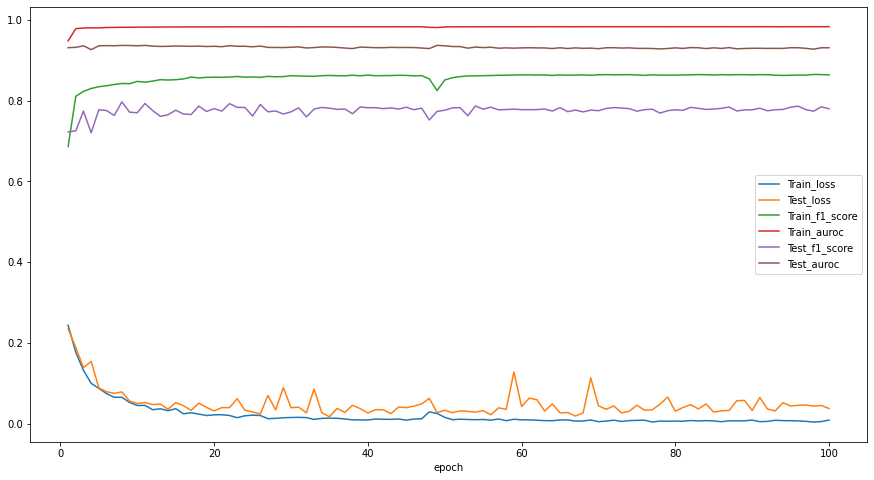

In [ ]:
import torch
import matplotlib.pyplot as plt
import cv2
import pandas as pd

df = pd.read_csv('./log.csv')
df.plot(x='epoch',figsize=(15,8));

In [ ]:
import cv2
import time
import torch
import matplotlib.pyplot as plt
t = time.time()

model = createDeepLabv3().to('cuda:0')
model.load_state_dict(torch.load('/content/drive/MyDrive/checkpoint_lane.pth'))#, map_location='cpu'))
model.eval()

ino = 1
# Read  a sample image and mask from the data-set
img = cv2.resize(cv2.imread('/content/Video010_008_u50.jpg'), (512, 512)).transpose(2,0,1)
# mask = cv2.resize(cv2.imread('/content/drive/MyDrive/LaneTrackingSet/Masks/Video010_008_u50.jpg'), (512, 512))


with torch.no_grad():
    a = model(torch.from_numpy(img).unsqueeze(0).type(torch.cuda.FloatTensor)/255)
# Plot the input image, ground truth and the predicted output

plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img.transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
probs = a['out'].cpu().detach().numpy()[0][0]
plt.imshow(probs>0)
plt.title('Segmentation Output')
plt.axis('off');

# do stuff
elapsed = time.time() - t
print(elapsed)

NameError: ignored

In [ ]:
import cv2

video = cv2.VideoCapture('TSTVID.mp4')
out = cv2.VideoWriter('TSTVID_MASK.mp4',cv2.VideoWriter_fourcc(*'XVID'), 20, (512,512))
frame_count = 0
while (video.isOpened()):

  # Capture frame-by-frame
  ret, frame = video.read()

  if ret == True:
    frame = cv2.resize(frame, (512, 512)).transpose(2,0,1)
    with torch.no_grad():
      a = model(torch.from_numpy(frame).unsqueeze(0).type(torch.cuda.FloatTensor)/255)
      probs = a['out'].cpu().detach().numpy()[0][0]
      mask = np.zeros_like(probs)
      mask[probs > 0] = 255
      # out.write(mask.astype('uint8'))
      cv2.imwrite('/content/drive/MyDrive/LaneTrackingSet/output_sequence/{}.jpg'.format(frame_count),
                  cv2.hconcat([cv2.cvtColor(frame.transpose(1,2,0), cv2.COLOR_BGR2GRAY).astype('uint8'), mask.astype('uint8')]))
      frame_count = frame_count + 1

    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
      break

  # Break the loop
  else:
    break


In [ ]:
mask = np.zeros_like(probs)
mask[probs>0] = 255
cv2.imwrite('mask.jpg', mask.astype('uint8'))

True

In [ ]:

np.array(probs[probs>0] * 255).astype('uint8')

array([ 37, 131, 247, ...,  16,   3,  62], dtype=uint8)

True



---



In [ ]:
torch.__version__

'1.8.1+cu101'